In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy as sc
import stlearn as st
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import sys



RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
data_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/'
save_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/results_temp/Mouse_Olfactory_Bulb/stLearn/'
os.makedirs(save_root, exist_ok=True)

In [3]:
counts_file = os.path.join(data_root, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_root, 'position.tsv')

counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')

counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

adata = sc.read_h5ad(os.path.join(data_root, 'raw.h5ad'))
adata.var_names_make_unique()

coords = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

used_barcode = pd.read_csv(os.path.join(data_root, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'x', 'y'
    obsm: 'spatial'

/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

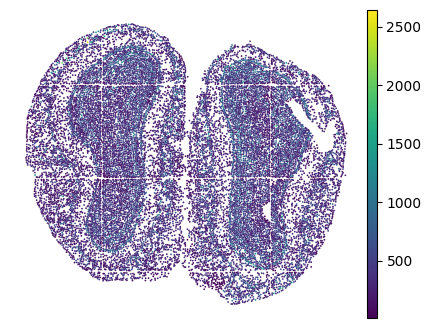

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [6]:
n_clusters = 7

data = adata.copy()

# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.em.run_pca(data,n_comps=15)
# st.pp.tiling(data, TILE_PATH)
# st.pp.extract_feature(data)

# stSME
# st.spatial.SME.SME_normalize(data, use_data="raw", weights="physical_distance")
# data_ = data.copy()
# data_.X = data_.obsm['raw_SME_normalized']
# st.pp.scale(data_)
# st.em.run_pca(data_,n_comps=30)
st.tl.clustering.kmeans(data, n_clusters=n_clusters, use_data="X_pca", key_added="X_pca_kmeans")

st.pp.neighbors(data, n_neighbors=10, use_rep="X_pca")
st.em.run_umap(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans cluster ...


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


/home/lytq/.conda/envs/stlearn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-18 05:11:50.371118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 05:11:50.494418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:
2025-02-18 05:11:50.494458: I tensorflow/compiler/xla/stream_executor/cuda/

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']


In [7]:
data

AnnData object with n_obs × n_vars = 19109 × 27092
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'X_pca_kmeans'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
data.obs['label_shift'] = (data.obs['X_pca_kmeans'].astype(int) + 1).astype('category')

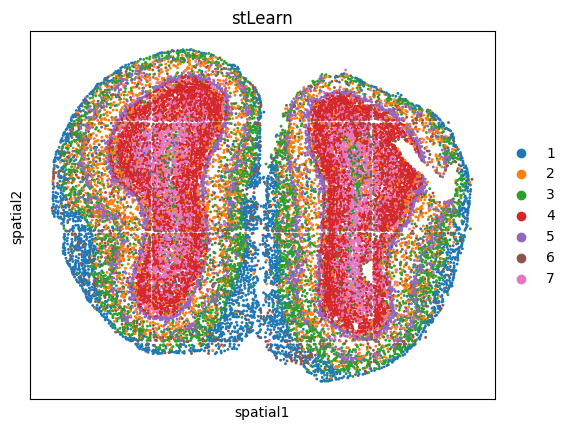

In [9]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(data, color="label_shift", show=False, title='stLearn', ax=ax, spot_size=40)
ax.invert_yaxis()
# plt.axis('off')
plt.savefig(os.path.join(save_root, 'clustering.pdf'), dpi=300, bbox_inches='tight')

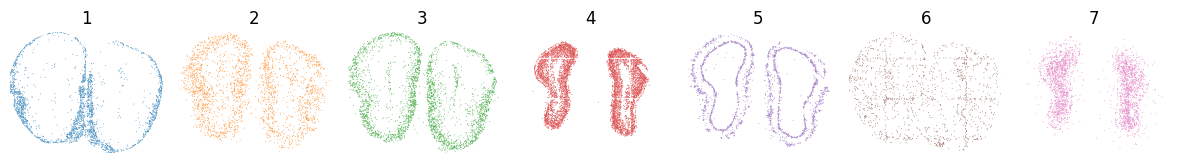

In [10]:
fig, axes = plt.subplots(1,n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = data[data.obs['label_shift'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='label_shift', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)


xmin = data.obsm['spatial'][:, 0].min()
xmax = data.obsm['spatial'][:, 0].max()
ymin = data.obsm['spatial'][:, 1].min()
ymax = data.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_root, f'each_cluster.pdf'), dpi=300, bbox_inches='tight')

In [11]:
cell_metadata = data.obs
cell_metadata

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,X_pca_kmeans,label_shift
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006,0,1
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000,0,1
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000,0,1
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993,1,2
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000,0,1
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000,0,1
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008,0,1
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000,5,6


In [12]:
cell_metadata.to_csv(os.path.join(save_root, 'cell_metadata.csv'))